In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState
import random
import pandas as pd
import numpy as np
import scipy as scp
from scipy import stats
from collections import namedtuple
import datetime
import copy
from dateutil.parser import parse


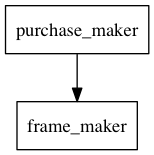

,date,event,item,quantity,price
0,2014-12-31,purchase,tractor,1,13541.48
1,2014-12-31,purchase,saw,10,13.41
2,2014-12-31,purchase,screws,100,0.08
3,2014-12-31,purchase,wheelbarrow,2,72.80
4,2014-12-31,purchase,trailer,1,683.92
5,2014-12-31,purchase,paint,13,26.11
6,2014-12-31,purchase,hammer,20,7.29
7,2015-01-01,sale,hammer,1,7.19
8,2015-01-01,sale,paint,1,25.95
9,2015-01-01,sale,screws,11,0.08


In [3]:
TransactionTup = namedtuple('TransactionTup', 'date event item quantity price')
ITEMS = ['hammer', 'saw', 'paint', 'wheelbarrow', 'trailer', 'tractor', 'screws']
PRICES = [13, 24, 47, 129, 1200, 24000, .15]
MONTHLY_RATES = [60, 30, 40, 6, 5, 4, 300]
ALPHA = 1600
BETA = 400
FIRST_DAY = datetime.datetime(2015, 1, 1)


def sales_generator(n_days):
    daily_rates = [r / 30. for r in MONTHLY_RATES]
    distributions = {
        item: stats.distributions.poisson(mu=rate)
        for (item, rate) in zip(ITEMS, daily_rates)
    }
    price_dist = {item: stats.beta(ALPHA, BETA) for (item, price) in zip(ITEMS, PRICES)}
    base_prices = {item: price for (item, price) in zip(ITEMS, PRICES)}

    for day_num in range(n_days):
        day = FIRST_DAY + datetime.timedelta(day_num)
        for (item, dist) in distributions.items():
            quantity = dist.rvs()
            if quantity:
                price = round(.7 * base_prices[item] * price_dist[item].rvs(), 2)
                yield TransactionTup(str(day.date()), 'sale', item, quantity, price)
            
class PurchaseMaker(Node):
    def begin(self):
        self.restock = {item: int(rate / 3.) for (item, rate) in zip(ITEMS, MONTHLY_RATES)}
        self.price_dist = {item: stats.beta(ALPHA, BETA) for (item, price) in zip(ITEMS, PRICES)}
        self.inventory = copy.copy(self.restock)
        self.bernoulli = stats.bernoulli(.75)
        self.base_prices = {item: price for (item, price) in zip(ITEMS, PRICES)}
        self.initial_event_list= []
        for item in self.restock.keys():
            quantity = self.restock[item]
            #price = float(item.price) * round(self.price_dist[item].rvs(), 2)
            #print '***', repr(self.base_prices[item])
            price = round(.7 * self.base_prices[item] * self.price_dist[item].rvs(), 2)
            self.initial_event_list.append(TransactionTup(
                    FIRST_DAY - datetime.timedelta(days=1),
                    'purchase',
                    item,
                    quantity,
                    price
                ))
                    
        
    def process(self, item):
        while self.initial_event_list:
            self.push(self.initial_event_list.pop())
        
        if self.inventory[item.item] < item.quantity:
            if self.bernoulli.rvs():
                restock_amount = self.restock[item.item]
                self.inventory[item.item] = restock_amount
                price = round(self.price_dist[item.item].rvs(), 2)
                self.push(TransactionTup(item.date, 'purchase', item.item, restock_amount, price))
        else:
            self.push(item)
            self.inventory[item.item] -= min([item.quantity, self.inventory[item.item]])

class FrameMaker(Node):
    def begin(self):
        self.recs = []
        
    def process(self, rec):
        self.recs.append(rec)
    
    def end(self):
        self.global_state.df = pd.DataFrame(self.recs, columns=TransactionTup._fields)

        
pipe = Pipeline(
        PurchaseMaker('purchase_maker')
        | FrameMaker('frame_maker')
        , global_state=GlobalState()
    )
pipe.plot(display_noteook=True)
pipe.consume(sales_generator(365 * 2)) 
df = pipe.global_state.df
df.to_csv('transactions.csv', index=False)
df.head(100)

In [ ]:
sorted(df.item.unique())